# Using CellTypist for cell type classification
This notebook is adapted from the [Celltypist tutorial notebook](https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb) by Teichlab.
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from either the built-in CellTypist models or the user-trained custom models.

Use the tmp_celltypist environment

In [1]:
import numpy as np
import scanpy as sc
import celltypist
from celltypist import models

In [ ]:
output_path = "TODO"
# Anndata object path
cells_adata_path = f"{output_path}/tmap/weighted_by_area|celltypist_cells_adata.h5"

model_name = "Human_Colorectal_Cancer.pkl"


In [3]:
adata = sc.read_h5ad(cells_adata_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 164273 × 18085
    obs: 'cell_type', 'patch_id'
    obsm: 'spatial', 'stats'

In [6]:
adata.obsm['stats']

,num_shared_bins,num_unique_bins,num_transcripts
id,,,
ID_1,6,13,31
ID_1021,14,18,492
ID_1022,13,6,239
ID_1023,10,7,100
ID_1028,14,7,249
...,...,...,...
ID_124067,0,17,3
ID_124068,0,10,7
ID_124073,0,45,11


This dataset includes 2,000 cells and 18,950 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [7]:
adata.shape

(164273, 18085)

The expression matrix (`adata.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [8]:
adata.X.expm1().sum(axis = 1)

matrix([[6.4453833e+02],
        [1.1457380e+15],
        [2.3902726e+07],
        ...,
        [2.8026783e+01],
        [8.3445034e+00],
        [2.0616047e+01]], shape=(164273, 1), dtype=float32)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [9]:
adata

AnnData object with n_obs × n_vars = 164273 × 18085
    obs: 'cell_type', 'patch_id'
    obsm: 'spatial', 'stats'

In [10]:
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)
adata.obs["lib_size"] = lib_size

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [12]:
adata.X.expm1().sum(axis = 1)

matrix([[ 9999.999],
        [10000.   ],
        [ 9999.999],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.002]], shape=(164273, 1), dtype=float32)

In [13]:
adata.obs

,cell_type,patch_id,size_factor,lib_size
id,,,,
ID_1,cd4_em/effector,patch_2_0.csv,0.216750,31.140989
ID_1021,secretory_club,patch_2_0.csv,3.426929,492.355377
ID_1022,secretory_club,patch_2_0.csv,1.665221,239.246353
ID_1023,cd4_em/effector,patch_2_0.csv,0.702389,100.913994
ID_1028,secretory_club,patch_2_0.csv,1.738132,249.721756
...,...,...,...,...
ID_124067,macro_alveolar,patch_0_6.csv,0.022867,3.285421
ID_124068,cd4_em/effector,patch_0_6.csv,0.051182,7.353504
ID_124073,macro_alveolar,patch_0_6.csv,0.082630,11.871607


## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from built-in models to the query dataset.

Download the latest CellTypist models.

In [ ]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

All models are stored in `models.models_path`.

Get an overview of the models and what they represent.

Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.

Transfer cell type labels from this model to the query dataset using [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.annotate.html).

In [16]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata, model = model_name, majority_voting = True)

🔬 Input data has 164273 cells and 18085 genes
🔗 Matching reference genes in the model
🧬 4503 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/misc/ngseq12/miniforge3/envs/tmp_celltypist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [17]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
id,,,
ID_1,B cells,589,Basal resting
ID_1021,Multiciliated (non-nasal),35,Multiciliated (non-nasal)
ID_1022,Multiciliated (non-nasal),293,Multiciliated (non-nasal)
ID_1023,Basal resting,404,Multiciliated (non-nasal)
ID_1028,Multiciliated (non-nasal),258,Multiciliated (non-nasal)
...,...,...,...
ID_124067,Basal resting,411,Basal resting
ID_124068,Basal resting,208,Basal resting
ID_124073,Basal resting,375,Basal resting


Transform the prediction result into an `AnnData`.

In [18]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.classifier.AnnotationResult.html#celltypist.classifier.AnnotationResult.to_adata).

In [19]:
adata.obs

,cell_type,patch_id,size_factor,lib_size,predicted_labels,over_clustering,majority_voting,conf_score
id,,,,,,,,
ID_1,cd4_em/effector,patch_2_0.csv,0.216750,31.140989,B cells,589,Basal resting,0.110155
ID_1021,secretory_club,patch_2_0.csv,3.426929,492.355377,Multiciliated (non-nasal),35,Multiciliated (non-nasal),0.898707
ID_1022,secretory_club,patch_2_0.csv,1.665221,239.246353,Multiciliated (non-nasal),293,Multiciliated (non-nasal),0.836587
ID_1023,cd4_em/effector,patch_2_0.csv,0.702389,100.913994,Basal resting,404,Multiciliated (non-nasal),0.326812
ID_1028,secretory_club,patch_2_0.csv,1.738132,249.721756,Multiciliated (non-nasal),258,Multiciliated (non-nasal),0.364363
...,...,...,...,...,...,...,...,...
ID_124067,macro_alveolar,patch_0_6.csv,0.022867,3.285421,Basal resting,411,Basal resting,0.032347
ID_124068,cd4_em/effector,patch_0_6.csv,0.051182,7.353504,Basal resting,208,Basal resting,0.663447
ID_124073,macro_alveolar,patch_0_6.csv,0.082630,11.871607,Basal resting,375,Basal resting,0.127601


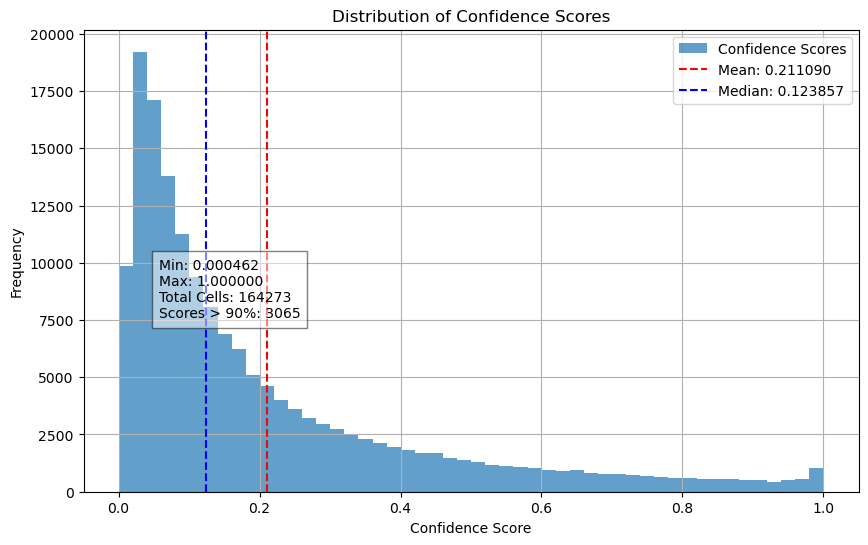

In [ ]:
import matplotlib.pyplot as plt

# Calculate mean, median, and total number of cells
mean_conf_score = adata.obs['conf_score'].mean()
median_conf_score = adata.obs['conf_score'].median()
total_cells = adata.obs['conf_score'].shape[0]

# Plot histogram
adata.obs['conf_score'].hist(bins=50, figsize=(10, 6), alpha=0.7, label='Confidence Scores')
plt.axvline(mean_conf_score, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_conf_score:.6f}')
plt.axvline(median_conf_score, color='blue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_conf_score:.6f}')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Display summary metrics
num_scores_above_90 = (adata.obs['conf_score'] > 0.9).sum()
summary_text = (
    f"Min: {adata.obs['conf_score'].min():.6f}\n"
    f"Max: {adata.obs['conf_score'].max():.6f}\n"
    f"Total Cells: {total_cells}\n"
    f"Scores > 90%: {num_scores_above_90}"
)
plt.figtext(0.2, 0.4, summary_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.show()

Compare the different celltypist models on this dataset

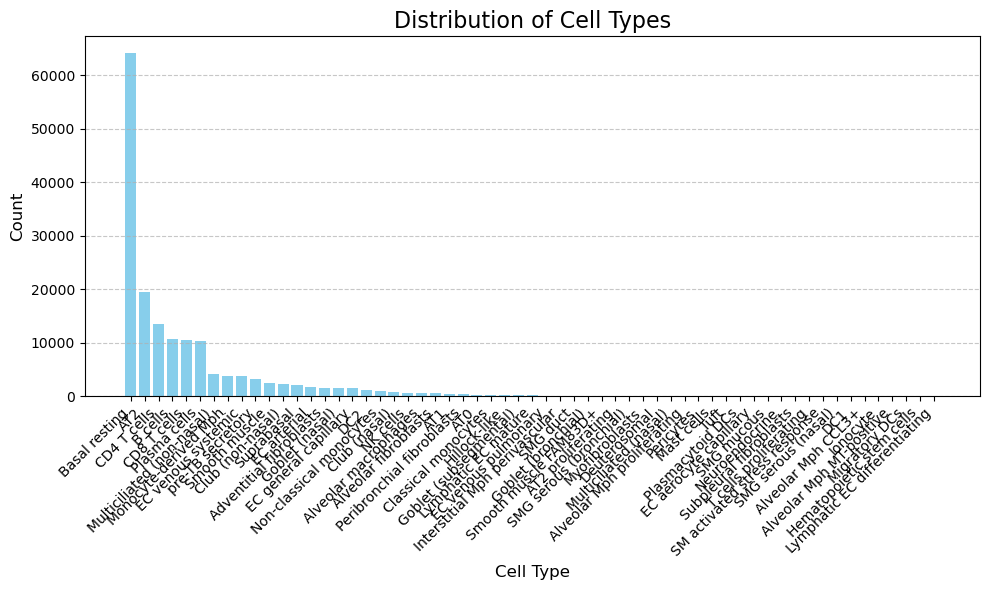

In [24]:
cell_type_counts = adata.obs["predicted_labels"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type pred", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type pred"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

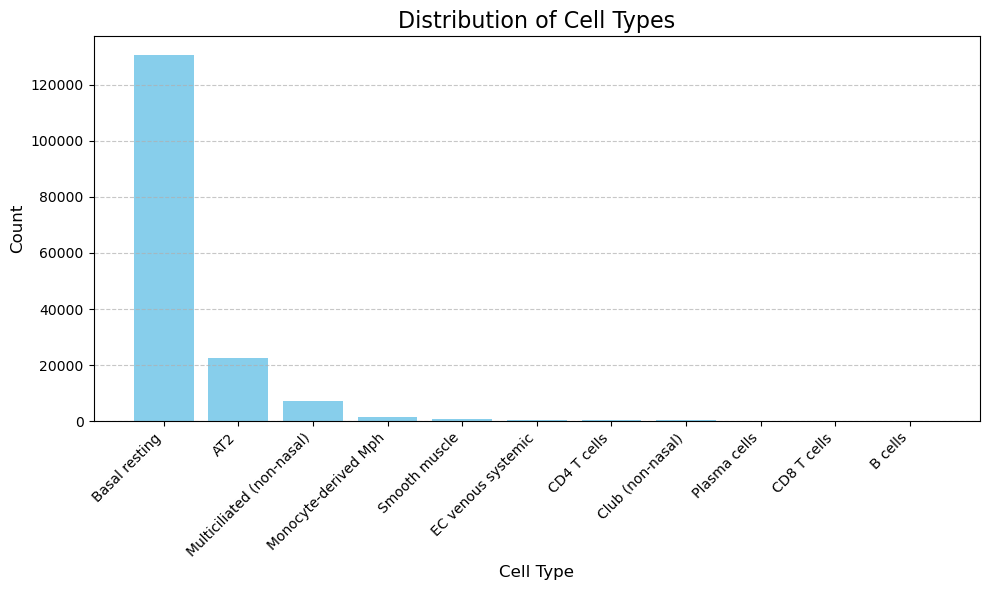

In [23]:
cell_type_counts = adata.obs["majority_voting"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata`
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

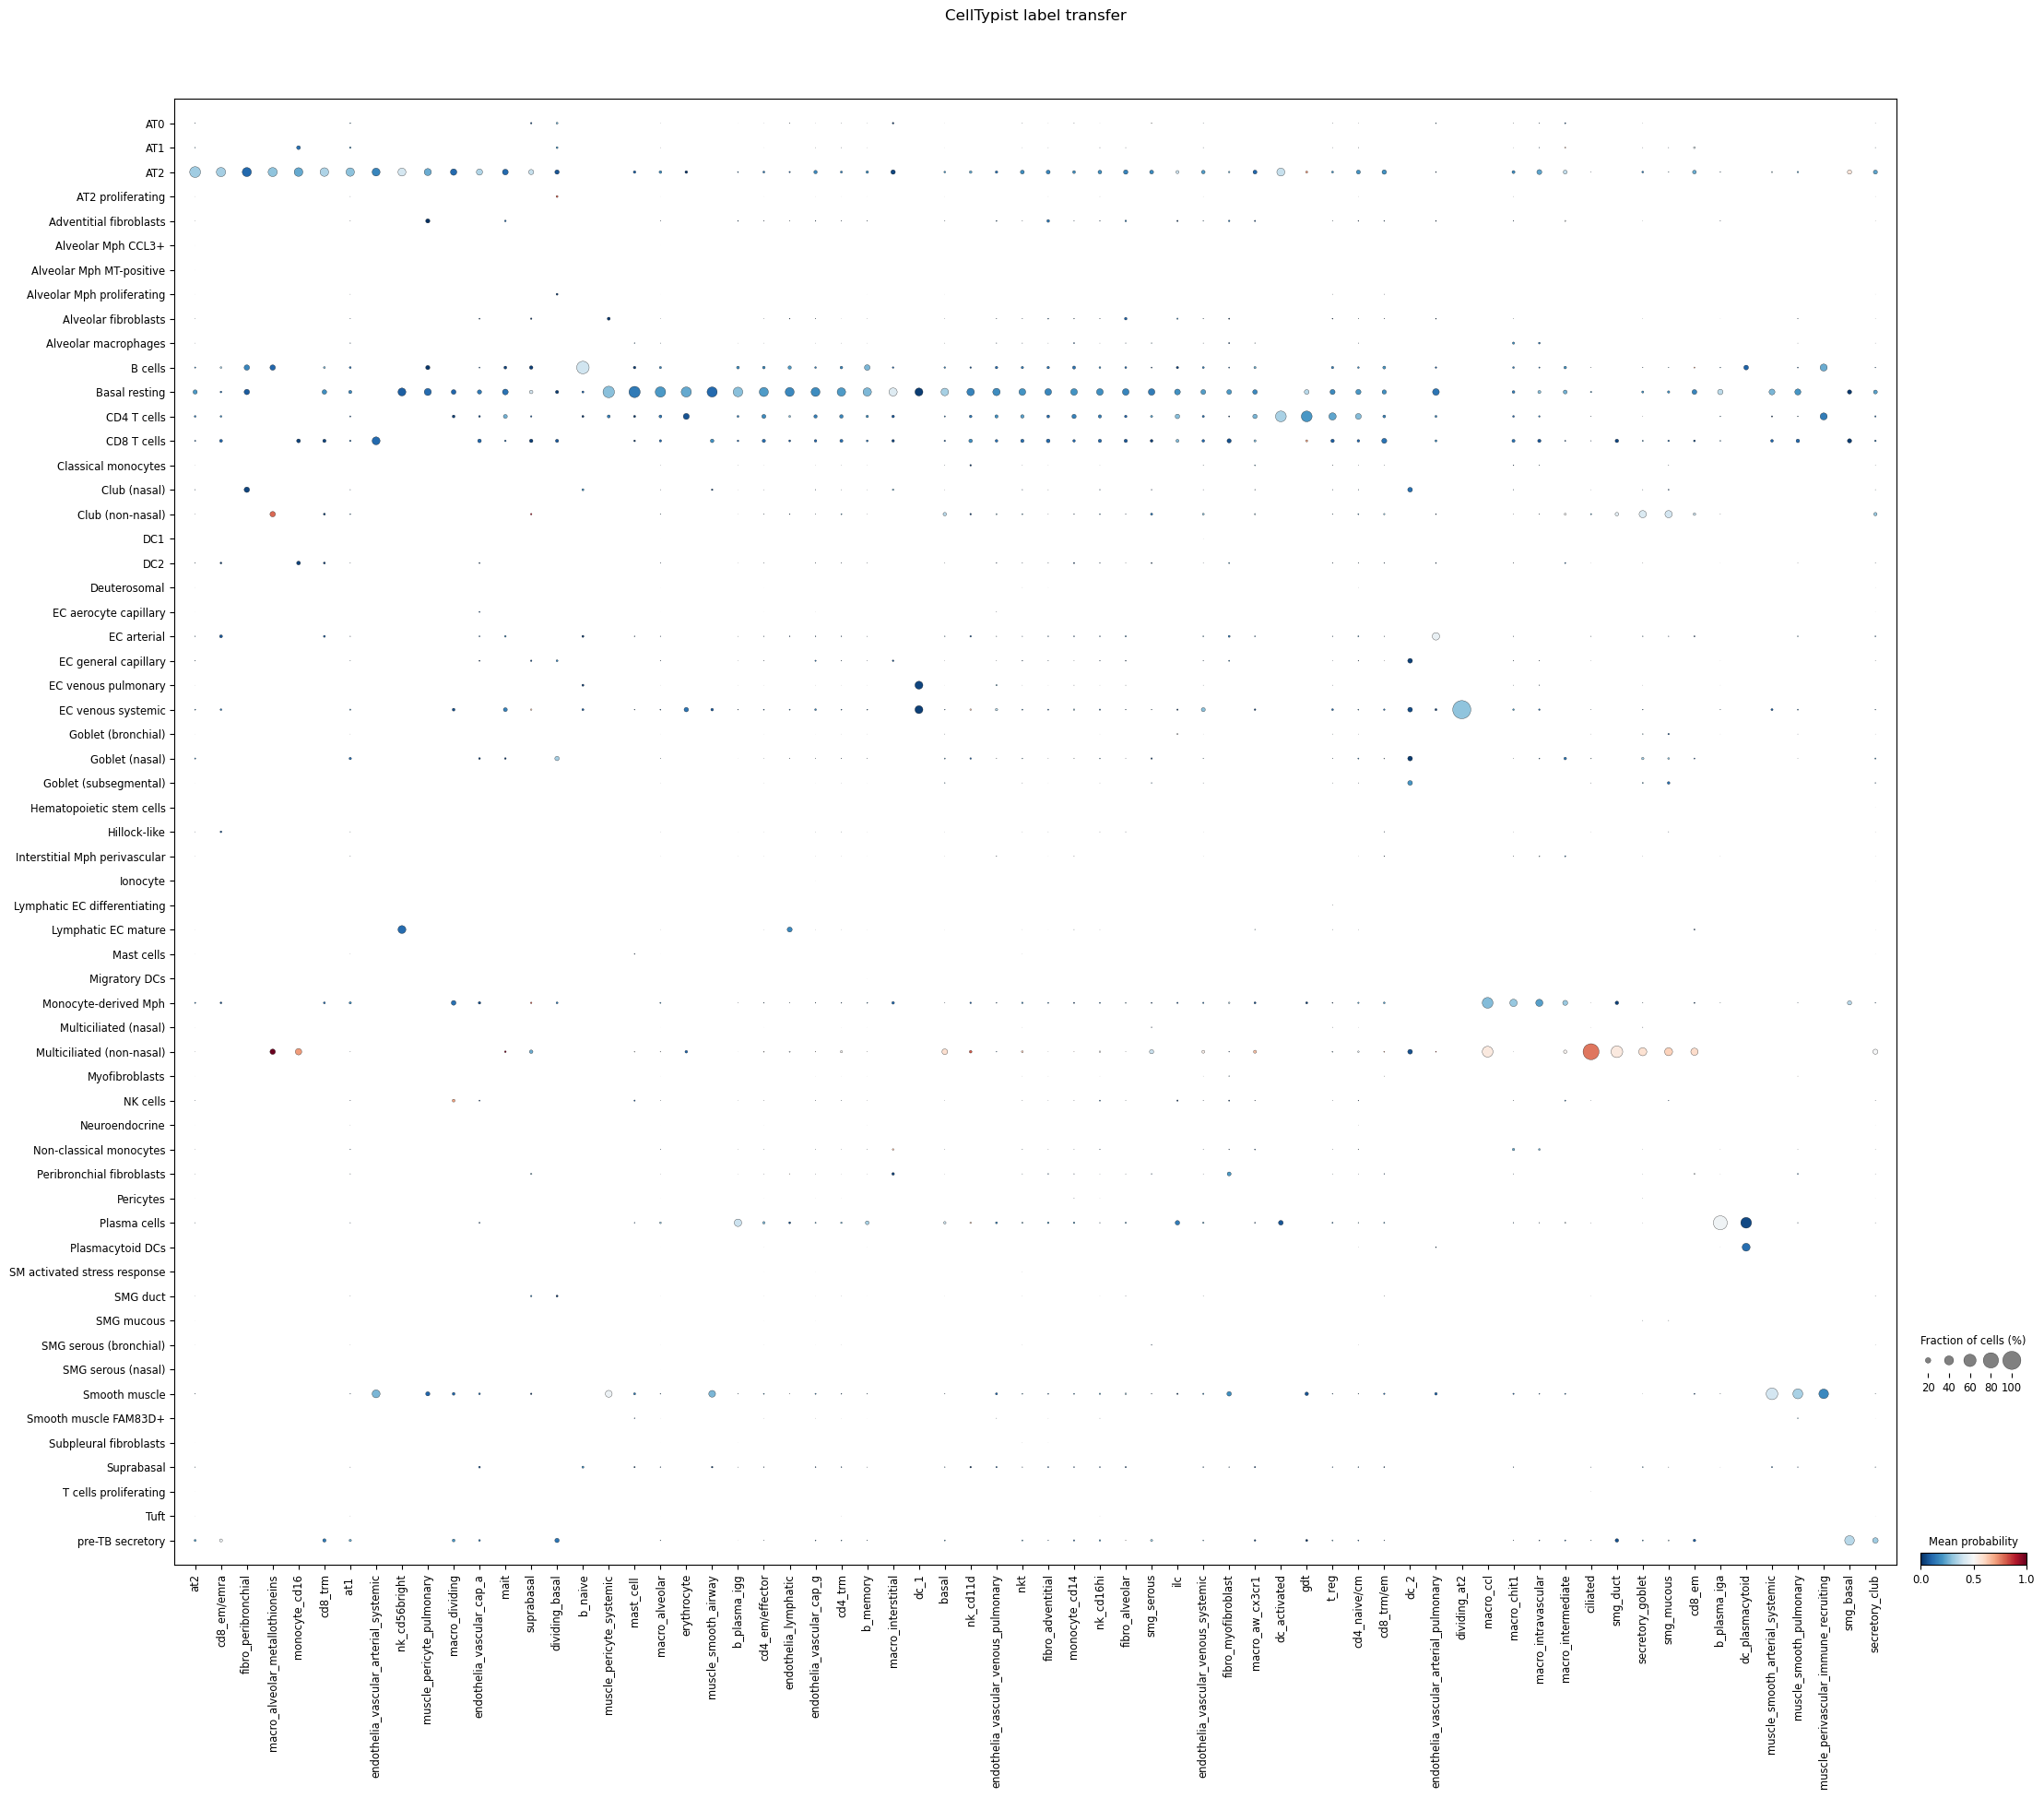

In [ ]:
celltypist.dotplot(predictions, use_as_reference = 'majority_voting', use_as_prediction = 'predicted_labels') #predictions are on the y axis